<a href="https://colab.research.google.com/github/Matvej911/DLBDSMTP01_Aleksejevs_9217531_Task1_2024_10_01/blob/main/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

###Data Generation for Anomaly Detection in Colab

####This code generates a synthetic dataset for anomaly detection, with 4000 samples, where 40% are anomalous. Normal data points are created with slight noise around typical values for temperature, humidity, and sound volume, while anomalous data covers a broader range of values. The dataset includes a target column indicating whether each sample is normal (0) or anomalous (1). Finally, the data is saved as a CSV file dataset.csv.

In [42]:

n_samples = 4000
n_anomalous = int(n_samples * 0.4)
n_normal = n_samples - n_anomalous

temperature_normal = np.random.normal(loc=24, scale=1.5, size=n_normal)
humidity_normal = np.random.normal(loc=52, scale=1.0, size=n_normal)
sound_volume_normal = np.random.normal(loc=60, scale=10, size=n_normal)

temperature_anomalous = np.random.uniform(low=19, high=28, size=n_anomalous)
humidity_anomalous = np.random.uniform(low=40, high=60, size=n_anomalous)
sound_volume_anomalous = np.random.uniform(low=30, high=100, size=n_anomalous)

temperature = np.concatenate([temperature_normal, temperature_anomalous])
humidity = np.concatenate([humidity_normal, humidity_anomalous])
sound_volume = np.concatenate([sound_volume_normal, sound_volume_anomalous])

target = np.concatenate([np.zeros(n_normal), np.ones(n_anomalous)])

df = pd.DataFrame({
    'temperature': temperature,
    'humidity': humidity,
    'sound_volume': sound_volume,
    'target': target
})

csv_path = 'dataset.csv'
df.to_csv(csv_path, index=False)




In [43]:
df = pd.read_csv('dataset.csv')
df.sample(5)

,temperature,humidity,sound_volume,target
1571,25.706325,52.728264,50.201965,0.0
1738,24.644221,51.946164,68.816704,0.0
3287,21.354535,54.243108,50.542611,1.0
1659,22.624763,50.799327,72.504598,0.0
3730,26.993507,51.796463,42.314682,1.0


In [44]:
category_counts = df['target'].value_counts()
category_counts

,count
target,
0.0,2400
1.0,1600


 ### Identifying and Evaluating Anomalies in Generated Data

In [45]:
condition = (
    (df['temperature'] >= 22) & (df['temperature'] <= 26) &
    (df['humidity'] >= 51) & (df['humidity'] <= 53) &
    (df['sound_volume'] < 80)
)

df['is_anomalous'] = ~condition

anomalies = df[df['is_anomalous'] == True]

correct_anomalies = anomalies[anomalies['target'] == 1].shape[0]
incorrect_normal = df[condition & (df['target'] == 1)].shape[0]

correct_anomalies, incorrect_normal, anomalies.shape[0]



(1542, 58, 2654)

In [46]:
df = df.drop(columns=['is_anomalous'])

### Data Rounding and Target Column Adjustment in Dataset

In [47]:
df[['temperature', 'humidity', 'sound_volume']] = df[['temperature', 'humidity', 'sound_volume']].apply(lambda x: x.round(1))

df['target'] = df['target'].astype(int)

In [48]:
df.head()

,temperature,humidity,sound_volume,target
0,23.2,52.9,60.5,0
1,23.3,52.0,63.1,0
2,23.8,50.7,48.5,0
3,25.3,53.2,59.6,0
4,24.1,52.0,60.6,0


###Shuffling and Splitting Dataset for aditional Testing

In [49]:
df = df.sample(frac=1).reset_index(drop=True)
df_testing = df[3800:]
df_testing.describe()

,temperature,humidity,sound_volume,target
count,200.000000,200.000000,200.000000,200.000000
mean,23.920500,51.131500,62.261500,0.390000
std,1.950964,3.807538,14.923549,0.488974
min,19.100000,40.200000,30.000000,0.000000
25%,22.900000,50.600000,52.775000,0.000000
50%,24.100000,51.850000,61.000000,0.000000
75%,25.300000,53.100000,70.750000,1.000000
max,27.900000,59.800000,99.100000,1.000000


In [50]:
df = df[:3800]
df.shape

(3800, 4)

In [51]:
df_testing1 = df_testing.drop(columns='target', axis=1)
df_testing1.to_csv(r"df_testing_without_target.csv", index=False)

In [52]:
df_testing.to_csv(r"df_testing.csv", index=False)

In [53]:
df.to_csv(r"dataset.csv", index=False)

In [54]:
df_testing.shape

(200, 4)

In [55]:
df.describe()

,temperature,humidity,sound_volume,target
count,3800.000000,3800.000000,3800.000000,3800.000000
mean,23.792053,51.127079,61.677684,0.400526
std,2.038869,3.836097,15.062414,0.490070
min,18.100000,40.000000,24.000000,0.000000
25%,22.500000,50.400000,51.600000,0.000000
50%,23.900000,51.800000,60.700000,0.000000
75%,25.200000,52.900000,70.500000,1.000000
max,29.200000,60.000000,99.800000,1.000000


### Removing Duplicate Entries from the Dataset

In [56]:
df.drop_duplicates(inplace=True)


### Data Type Correction and Visual Analysis with Pairplot and Heatmap

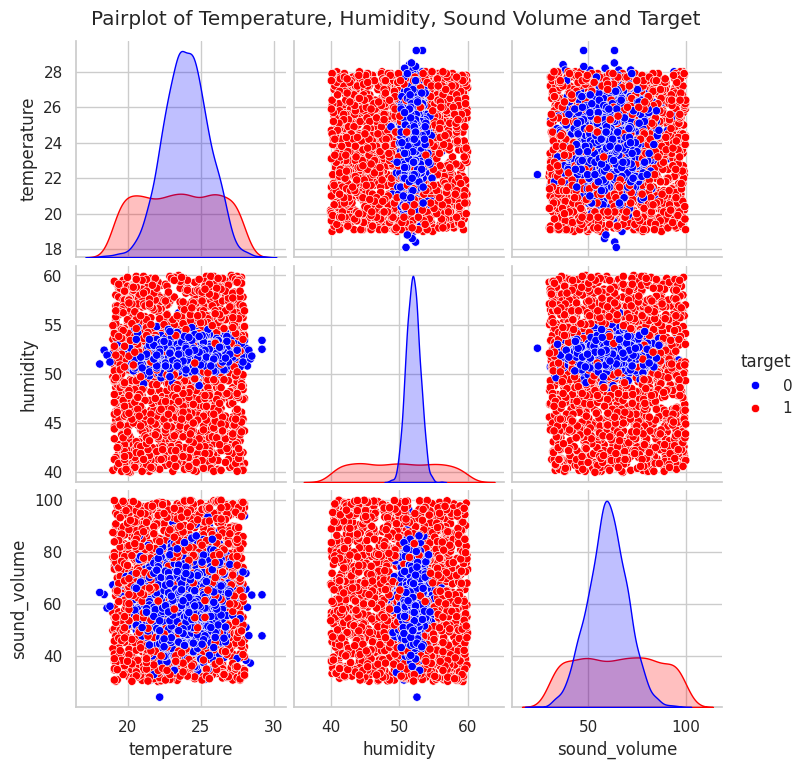

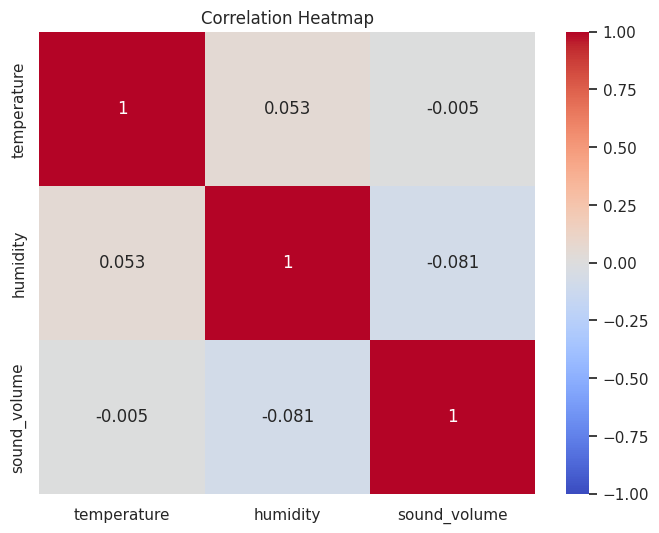

In [57]:
df.dtypes

df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')
df['sound_volume'] = pd.to_numeric(df['sound_volume'], errors='coerce')


sns.set(style='whitegrid')

pairplot = sns.pairplot(df, hue='target', palette={0: 'blue', 1: 'red'}, diag_kind='kde')

plt.suptitle("Pairplot of Temperature, Humidity, Sound Volume and Target", y=1.02)
plt.show()

plt.figure(figsize=(8, 6))
correlation_matrix = df[['temperature', 'humidity', 'sound_volume']].corr()

heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title("Correlation Heatmap")
plt.show()

### Model Training, Evaluation, and Saving Best Classifier

#### This code splits the dataset into training and testing sets and scales the features using StandardScaler. It evaluates five machine learning models: Logistic Regression, Random Forest, Support Vector Machine, K-Nearest Neighbors, and Gradient Boosting, using cross-validation to estimate performance. After training each model, it calculates accuracy and displays a classification report on the test set. The model with the highest test accuracy is saved as best_model_colab.pkl, along with the fitted scaler as scaler_colab.pkl, for future use.

In [58]:
X = df[['temperature', 'humidity', 'sound_volume']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

best_model = None
best_accuracy = 0

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"Model: {name}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.4f}")

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print('-' * 50)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"Best model: {best_model}")
print(f"Best accuracy: {best_accuracy:.4f}")

Model: Logistic Regression
Cross-validation scores: [0.76973684 0.75822368 0.76315789 0.75453048 0.75617792]
Mean CV accuracy: 0.7604
Test Accuracy: 0.7684
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       452
           1       0.92      0.47      0.62       308

    accuracy                           0.77       760
   macro avg       0.82      0.72      0.73       760
weighted avg       0.81      0.77      0.75       760

--------------------------------------------------
Model: Random Forest
Cross-validation scores: [0.94572368 0.93256579 0.91940789 0.91927512 0.91762768]
Mean CV accuracy: 0.9269
Test Accuracy: 0.9118
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       452
           1       0.93      0.85      0.89       308

    accuracy                           0.91       760
   macro avg       0.91      0.90      0.91       760
weighted avg       0.91      0.91      0.91 

###Loading and Evaluating Model on New  Data

In [59]:
df_test = pd.read_csv('/content/df_testing.csv')

X_test_new = df_test[['temperature', 'humidity', 'sound_volume']]
y_test_new = df_test['target']

with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

X_test_new_scaled = loaded_scaler.transform(X_test_new)

y_pred_new = loaded_model.predict(X_test_new_scaled)

accuracy_new = accuracy_score(y_test_new, y_pred_new)
print(f"Accuracy on new test data: {accuracy_new:.4f}")
print(classification_report(y_test_new, y_pred_new))


Accuracy on new test data: 0.9250
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       122
           1       0.93      0.87      0.90        78

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200

